# Predicting Substance Abuse: Survey Efficacy Analysis

## 1: Business Understanding
In the face of the ongoing substance abuse crisis, it's essential to identify individuals at risk of substance abuse as early as possible. This project is designed to support stakeholders, such as healthcare providers, addiction counselors, and policymakers, by evaluating two different surveys to see which one better predicts substance misuse. By finding the most reliable survey, we aim to empower these stakeholders with insights that help in early intervention and targeted support.

### 1.1: Objective
We have data from two distinct surveys, each containing information that may indicate potential risk factors for substance abuse. However, it’s unclear which survey provides a stronger basis for accurate prediction. Our goal is to determine which dataset better identifies individuals at risk of substance misuse, ultimately guiding our stakeholders toward the most effective tool for their work.

### 1.2: Method
To achieve this, we will employ a **machine learning classification model**. This model will analyze various factors within each survey dataset and classify individuals as either "at-risk" or "not at risk" for substance abuse. By comparing the accuracy and reliability of the predictions made from each survey, we can identify which survey holds greater predictive power.

---

This approach will not only give a clear comparison but also offer data-driven insights into how future surveys can be designed in order to better serve the community in the fight against substance abuse.


## 2: Data Understanding

### 2.1: Data Sources
We are working with two datasets obtained from survey data on substance abuse and related risk factors. The two datasets are:
- **PRLMIS Data**: This dataset contains survey responses from the National Survey on Drug Use and Health (NSDUH) from 2015 to 2017. It includes information on demographic, socioeconomic, and health-related factors, along with indicators of substance use and mental health treatment.
- **Student Addiction Data**: This dataset contains responses from a survey focused on addiction risk factors among students, capturing behaviors and experiences that may indicate addiction risk, such as experimentation, social isolation, and academic performance decline.

These datasets are suitable for this project because they contain potential risk indicators relevant to opioid abuse. Comparing these surveys allows us to determine which dataset is more effective in identifying individuals at risk.


### 2.2: Dataset Overview

Importing Necessary Libraries

To start, we will import all the libraries necessary for data manipulation, visualization, and building and evaluating classification models. This includes libraries for handling data (`pandas`, `numpy`), visualization (`matplotlib`, `seaborn`), and machine learning models (`sklearn` and `xgboost`).

The imported libraries cover all steps in our workflow, from loading and exploring the data to building and evaluating models.

In [1]:
# Data manipulation and analysis
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning models and tools
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from imblearn.over_sampling import SMOTE


# Model evaluation
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    classification_report
)

# Ignore warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')


### 2.3: Create functions to cut down on redundancy and make code cleaner

Defining functions at the start helps organize the workflow, making tasks like analyzing variables, selecting features, and modeling reusable and efficient. This saves time, reduces errors, and keeps the notebook cleaner, letting us focus on understanding results rather than repeating code.












In [2]:
def target_variable_analysis(data, target_col):
    """
    Analyzes the distribution of the target variable.
    Prints the distribution and plots a bar chart of the target variable.
    """
    target_distribution = data[target_col].value_counts(normalize=True) * 100
    print(f"\nTarget Variable ({target_col}) Distribution:")
    print(target_distribution)
    
    plt.figure(figsize=(8, 5))
    target_distribution.plot(kind='bar', color=['skyblue', 'salmon'])
    plt.title(f"Distribution of {target_col}")
    plt.xlabel(target_col)
    plt.ylabel("Percentage of Records")
    plt.show()



def select_top_features(data, target_col, total_features=10, required_features=None):
    """
    Selects top features using a Decision Tree and ensures specific features are included.
    
    Returns:
    - A DataFrame with selected top features and the target column.
    - importance_df: DataFrame showing features and their importance scores.
    """
    # Drop rows with NaN values across the entire dataset and reset index
    data = data.dropna().reset_index(drop=True)
    
    # Separate features and target
    X = data.drop(columns=[target_col])
    y = data[target_col]
    
    # Encode categorical variables if needed
    X_encoded = pd.get_dummies(X, drop_first=True)
    
    # Initialize Decision Tree model
    model = DecisionTreeClassifier(random_state=42)
    model.fit(X_encoded, y)
    
    # Get feature importance scores
    feature_importances = pd.Series(model.feature_importances_, index=X_encoded.columns)
    
    # Start with required features if specified, to ensure they are included
    selected_features = required_features if required_features else []
    
    # Calculate how many additional features we need to reach exactly `total_features`
    num_additional_features = total_features - len(selected_features)
    
    # Select the top N additional features based on importance scores
    additional_features = feature_importances.nlargest(num_additional_features).index.tolist()
    
    # Combine required and additional features to get exactly 10 features
    final_feature_names = selected_features + additional_features[:num_additional_features]
    
    # Filter the DataFrame to include only the selected top features and target column
    selected_data = X_encoded[final_feature_names]
    selected_data[target_col] = y  # Add target column to the final DataFrame
    
    # Create a DataFrame with importance scores and percentage contributions
    top_feature_importances = feature_importances[final_feature_names]
    importance_df = pd.DataFrame({
        'Feature': top_feature_importances.index,
        'Importance Score': top_feature_importances.values
    })
    importance_df['Percentage (%)'] = (importance_df['Importance Score'] / importance_df['Importance Score'].sum()) * 100
    importance_df = importance_df.sort_values(by='Importance Score', ascending=False).reset_index(drop=True)  # Sort descending
    
    # Plot feature importance for the top selected features
    plt.figure(figsize=(8, 6))
    importance_df.sort_values(by='Importance Score', ascending=True).plot(kind='barh', x='Feature', y='Importance Score', color='skyblue')
    plt.title(f"Top Features by Importance for {target_col}")
    plt.xlabel("Feature Importance Score")
    plt.gca().invert_yaxis()
    plt.show()
    
    return selected_data, importance_df



def prepare_data(selected_data, target_col, test_size=0.2):
    """
    Prepares data for modeling by splitting into train and test sets.
    
    Parameters:
    - selected_data: The dataset with selected top features and target column (DataFrame)
    - target_col: The target variable name (string)
    - test_size: Proportion of the dataset to include in the test split (default is 0.2)
    
    Returns:
    - X_train, X_test, y_train, y_test: Training and test sets for features and target
    """
    # Split the data into features and target
    X = selected_data.drop(columns=[target_col])
    y = selected_data[target_col]
    
    # Perform the train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    
    # Print train-test split shapes
    print(f"\nData prepared for target '{target_col}':")
    print("Training set shape (features):", X_train.shape)
    print("Training set shape (target):", y_train.shape)
    print("Testing set shape (features):", X_test.shape)
    print("Testing set shape (target):", y_test.shape)
    
    return X_train, X_test, y_train, y_test



def train_and_evaluate_logistic_regression(X_train, X_test, y_train, y_test, dataset_name):
    """
    Trains and evaluates a logistic regression model, printing accuracy, classification report,
    and displaying a confusion matrix.
    
    Parameters:
    - X_train, X_test: Training and testing feature sets
    - y_train, y_test: Training and testing target sets
    - dataset_name: Name of the dataset (string) for display purposes
    """
    # Initialize the logistic regression model
    model = LogisticRegression(random_state=42, max_iter=1000)
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Print accuracy and classification report
    print(f"\nLogistic Regression Results for {dataset_name} Dataset:")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    
    # Generate and display the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No", "Yes"], yticklabels=["No", "Yes"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix for Logistic Regression on {dataset_name} Dataset")
    plt.show()


### 2.4: Loading the Datasets

Next, we will load the two datasets we will be working with:
1. **PRLMIS Data**: A dataset from the National Survey on Drug Use and Health (NSDUH) containing demographic and health-related data.
2. **Student Addiction Data**: A student-focused survey dataset containing indicators related to addiction risk.

After loading each dataset, we will display some basic information and the first few rows to understand the data structure.

In [3]:
# Load the datasets
prlmis_data = pd.read_csv('data/prlmis-data-full.csv')
student_addiction_data = pd.read_csv('data/student_addiction_dataset_train.csv')

# Display basic information and the first few rows for each dataset
print("PRLMIS Data (National Survey Data):")
print(prlmis_data.info())
print(prlmis_data.head())

print("\nStudent Addiction Data (Student Survey Data):")
print(student_addiction_data.info())
print(student_addiction_data.head())


PRLMIS Data (National Survey Data):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170317 entries, 0 to 170316
Data columns (total 21 columns):
 #   Column     Non-Null Count   Dtype
---  ------     --------------   -----
 0   YEAR       170317 non-null  int64
 1   AGECAT     170317 non-null  int64
 2   SEX        170317 non-null  int64
 3   MARRIED    170317 non-null  int64
 4   EDUCAT     170317 non-null  int64
 5   EMPLOY18   170317 non-null  int64
 6   CTYMETRO   170317 non-null  int64
 7   HEALTH     170317 non-null  int64
 8   MENTHLTH   170317 non-null  int64
 9   PRLMISEVR  170317 non-null  int64
 10  PRLMISAB   170317 non-null  int64
 11  PRLANY     170317 non-null  int64
 12  HEROINEVR  170317 non-null  int64
 13  HEROINUSE  170317 non-null  int64
 14  TRQLZRS    170317 non-null  int64
 15  SEDATVS    170317 non-null  int64
 16  COCAINE    170317 non-null  int64
 17  AMPHETMN   170317 non-null  int64
 18  HALUCNG    170317 non-null  int64
 19  TRTMENT    170317 non-null  i

### 2.5: Descriptive Statistics and Initial Data Exploration

With both datasets loaded, we will calculate descriptive statistics to better understand the data distributions. 

Since most features in the PRLMIS Data represent categories (e.g., age groups, employment status), it is more useful to look at the frequency of each category within these features. This will help us understand the distribution of responses for each variable, which is essential for analyzing how these factors might relate to substance abuse risk.

We will calculate the frequency counts for each categorical feature.

The Student Addiction Data primarily consists of binary categorical features (`Yes`/`No`) that indicate various behavioral, social, and health-related factors associated with addiction risk. Additionally, the target variable `Addiction_Class` specifies whether a student is at risk of addiction.

To understand the distribution of responses, we will:
1. Calculate the frequency of `Yes` and `No` responses for each feature.
2. Check for any missing values, which may need to be addressed before modeling.
3. Examine the distribution of the target variable (`Addiction_Class`) to see if there is any class imbalance that could affect model performance.

This analysis provides insight into the makeup of the dataset, helping us interpret which factors are prevalent among individuals classified as at risk versus those not at risk.


This exploration helps us to identify the key characteristics of each dataset and any initial observations, such as missing values or outliers.



In [4]:
# Category counts for categorical features in PRLMIS Data
print("\nCategory Counts for PRLMIS Data:")
for column in prlmis_data.columns:
    if prlmis_data[column].dtype == 'int64' or prlmis_data[column].dtype == 'object':
        print(f"\n{column} Value Counts:")
        print(prlmis_data[column].value_counts())


# Descriptive statistics for Student Addiction Data
print("\nDescriptive Statistics for Student Addiction Data:")
student_addiction_desc = student_addiction_data.describe(include='all')
print(student_addiction_desc)

# Frequency counts for categorical features in Student Addiction Data
print("\nFrequency Counts for Key Features in Student Addiction Data:")
for column in student_addiction_data.columns:
    if student_addiction_data[column].dtype == 'object':
        print(f"{column} Value Counts:")
        print(student_addiction_data[column].value_counts())
        print()



Category Counts for PRLMIS Data:

YEAR Value Counts:
15    57146
16    56895
17    56276
Name: YEAR, dtype: int64

AGECAT Value Counts:
2    42053
1    41577
4    33744
3    26621
5    26322
Name: AGECAT, dtype: int64

SEX Value Counts:
1    89404
0    80913
Name: SEX, dtype: int64

MARRIED Value Counts:
0    70799
1    52680
4    35130
2     9220
3     2488
Name: MARRIED, dtype: int64

EDUCAT Value Counts:
4    43227
1    41577
3    34357
5    33973
2    17183
Name: EDUCAT, dtype: int64

EMPLOY18 Value Counts:
0    83379
2    66589
1    20349
Name: EMPLOY18, dtype: int64

CTYMETRO Value Counts:
0    57146
3    50760
2    39716
1    22695
Name: CTYMETRO, dtype: int64

HEALTH Value Counts:
2    62262
3    44241
1    40400
4    18424
5     4322
6      605
7       37
0       26
Name: HEALTH, dtype: int64

MENTHLTH Value Counts:
0     116859
1      22726
2       5572
5       5411
4       5373
3       5256
6       4159
7       2460
8       1381
9        687
10       433
Name: MENTHLTH, dty

### 2.6: Checking for Missing Values

Missing values can impact model performance and may require cleaning or imputation. We’ll check both datasets for missing values to identify any columns that need attention.

This step helps ensure data quality, allowing us to address any gaps before moving forward.


In [5]:
# Check for missing values in both datasets
print("\nMissing Values in PRLMIS Data:")
print(prlmis_data.isnull().sum())

print("\nMissing Values in Student Addiction Data:")
print(student_addiction_data.isnull().sum())



Missing Values in PRLMIS Data:
YEAR         0
AGECAT       0
SEX          0
MARRIED      0
EDUCAT       0
EMPLOY18     0
CTYMETRO     0
HEALTH       0
MENTHLTH     0
PRLMISEVR    0
PRLMISAB     0
PRLANY       0
HEROINEVR    0
HEROINUSE    0
TRQLZRS      0
SEDATVS      0
COCAINE      0
AMPHETMN     0
HALUCNG      0
TRTMENT      0
MHTRTMT      0
dtype: int64

Missing Values in Student Addiction Data:
Experimentation                       2562
Academic_Performance_Decline          2498
Social_Isolation                      2550
Financial_Issues                      2537
Physical_Mental_Health_Problems       2454
Legal_Consequences                    2576
Relationship_Strain                   2543
Risk_Taking_Behavior                  2577
Withdrawal_Symptoms                   2612
Denial_and_Resistance_to_Treatment    2453
Addiction_Class                          0
dtype: int64


### 2.7: Handling Missing Values in Student Addiction Data

After analyzing the missing values in the **Student Addiction Data**, we found that approximately 2,000 rows contain missing values across various features. With a total of 50,342 rows in the dataset, this accounts for only about **4%** of the data. 

Given that this percentage is relatively low, we have decided to **remove rows with missing values** rather than impute them. This approach has several benefits:
1. **Minimal Impact on Data Distribution**: Removing 4% of rows is unlikely to significantly affect the overall distribution, patterns, or insights within the dataset.
2. **Simplicity and Integrity**: Dropping rows is straightforward and avoids introducing any assumptions about the nature of the missing values, which preserves the integrity of the remaining data.

By taking this approach, we retain a clean dataset for modeling without compromising on data quality or complexity.


In [6]:
# Drop rows with any missing values in Student Addiction Data
student_addiction_data_cleaned = student_addiction_data.dropna()

# Display new shape to confirm reduction
print("Original data shape:", student_addiction_data.shape)
print("New data shape after dropping missing rows:", student_addiction_data_cleaned.shape)
print("Data shape of PRLMIS:", prlmis_data.shape)

Original data shape: (50342, 11)
New data shape after dropping missing rows: (30072, 11)
Data shape of PRLMIS: (170317, 21)


### 2.8: Creating a New Feature

After handling missing values, we created a new feature called `HEROINAB` for "Heroin Abuse". This feature indicates significant heroin use:
- If a person’s heroin use score (`HEROINUSE`) is above 2.5, `HEROINAB` is set to `1` (high heroin use).
- If their score is 2.5 or below, `HEROINAB` is set to `0` (low heroin use).

This new feature simplifies the analysis by focusing on high versus low heroin use, helping us better understand and predict opioid abuse risk, which is a massive component of the substance abuse issue across the country.


In [7]:
# Create HEROINAB feature in PRLMIS Data based on HEROINUSE threshold
prlmis_data['HEROINAB'] = prlmis_data['HEROINUSE'].apply(lambda x: 1 if x > 2.5 else 0)

# Verify the distribution of HEROINAB values
print("HEROINAB distribution:")
print(prlmis_data['HEROINAB'].value_counts())


HEROINAB distribution:
0    169739
1       578
Name: HEROINAB, dtype: int64


### 2.9: Target Variable Analysis

In this section, we will analyze the target variable in each dataset to understand its distribution. This analysis is essential because an imbalanced target variable can impact model performance, especially in classification tasks. If one class significantly outnumbers the other, we may need to adjust our modeling approach or evaluation metrics to ensure reliable results.

1. **PRLMIS Data**: The target variable in this dataset is `PRLMISEVR`, an binary variable indicating levels of prescription opioid misuse and abuse.
2. **Student Addiction Data**: The target variable is `Addiction_Class`, a binary variable indicating whether a student is at risk of addiction (`Yes`) or not at risk (`No`).


Target Variable (PRLMISEVR) Distribution:
0    89.29232
1    10.70768
Name: PRLMISEVR, dtype: float64


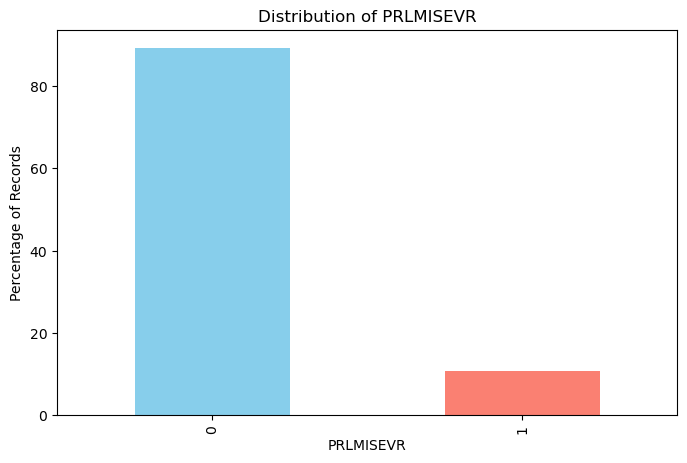


Target Variable (Addiction_Class) Distribution:
No     69.676111
Yes    30.323889
Name: Addiction_Class, dtype: float64


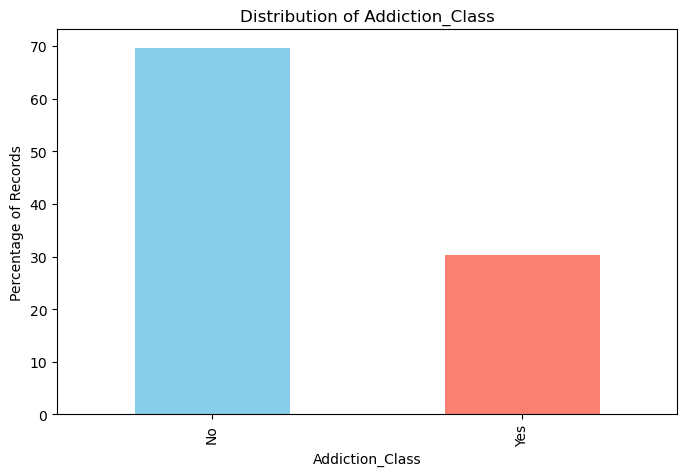

In [8]:
# Analyze target variable in PRLMIS Data
target_variable_analysis(prlmis_data, target_col='PRLMISEVR')

# Analyze target variable in Student Addiction Data (after removing missing rows)
target_variable_analysis(student_addiction_data_cleaned, target_col='Addiction_Class')


### 2.10: Data Understanding Summary

Here’s what we learned about our two datasets during the data understanding phase:

1. **What’s in the Data**:
   - **PRLMIS Data**: This dataset contains information about people’s demographics, health, and substance use. It has a column called `PRLMISEVR` that tells us if someone has misused prescription drugs and to what extent.
   - **Student Addiction Data**: This dataset focuses on factors that may show addiction risk among students, like social behaviors and health issues. It has a column called `Addiction_Class` that indicates if a student is considered at risk for addiction.

2. **Missing Information**:
   - **PRLMIS Data**: This dataset is complete with no missing values.
   - **Student Addiction Data**: Around 4% of rows had some missing information in certain columns. We removed these rows since it didn’t significantly reduce the amount of data.

3. **Target Variables**:
   - **PRLMIS Data (`PRLMISEVR`)**: Most records show no opioid misuse (about 89%). Since this imbalance is high, we may need to adjust our analysis to give more attention to the cases where misuse was reported.
   - **Student Addiction Data (`Addiction_Class`)**: Around 70% of students are labeled as "not at risk," while about 30% are "at risk." This is a smaller imbalance but still something to keep in mind during analysis.


With this understanding, we are ready to proceed to **Data Preparation and Feature Engineering** to ensure both datasets are aligned and suitable for modeling.


### 2.11: Data Limitations

In assessing substance abuse risk, each dataset has certain limitations that impact its predictive power. Understanding these limitations is important for interpreting the model’s results and identifying areas where additional data could improve prediction accuracy.

 * The PRLMIS dataset includes a range of features that touch on mental health, substance use history, and demographic factors. While these features are valuable for predicting substance abuse risk, there are some limitations. First, the data relies heavily on self-reported behaviors, which may not always be accurate due to factors like stigma or recall bias. Additionally, while PRLMIS captures substance use history and health factors, it may lack detailed information on environmental influences or social support systems, which can also play a role in substance abuse risk. This could lead to a model that is less sensitive to individuals at risk due to social or family-related factors.

* The Student Addiction dataset is more focused on factors commonly associated with younger individuals, such as academic performance, peer influence, and certain behavioral indicators. This focus can be valuable for identifying early warning signs of substance abuse. However, the dataset’s narrower scope also presents limitations. It does not include detailed information on prior substance use, what kind of substance was used, or mental health history, all of which are key indicators of substance abuse risk. Without these factors, the model may overlook certain aspects of risk that are critical for more comprehensive prediction, especially for individuals with a history of substance use or mental health challenges.
 
* Both datasets share some general limitations. Neither includes highly individualized data, such as personal family history of substance abuse or specific environmental stressors like job loss or financial instability, which can be significant in understanding an individual's risk. Additionally, both datasets rely on self-reported data, which may introduce biases and affect data accuracy. Finally, some variables may lack sufficient depth; for example, mental health indicators are often broad, while more detailed mental health assessments could provide additional insights.

In summary, while both datasets offer valuable information for substance abuse risk prediction, they each lack certain dimensions that could improve model accuracy. Recognizing these limitations highlights the importance of refining survey questions or collecting additional data to create a more comprehensive predictive model in the future.


## 3: Data Preparation

### 3.1: Feature Engineering: Selecting Top Features

1. **Understanding Feature Importance Using a Decision Tree**

   - **Goal**: Identify which factors (features) in each dataset are the most influential in predicting substance abuse risk.
   - **How It Works**: Think of the Decision Tree like a decision-making process that asks questions about each factor to determine how much it contributes to predicting risk. For example, it might check if certain health conditions or behaviors are strong indicators of opioid misuse.
   - **Outcome**: Each factor gets a score based on how often it helps make accurate predictions. The higher the score, the more "important" the factor is in the decision-making process.

2. **Selecting the Top 10 Most Predictive Features**

   - **Goal**: Focus on only the 10 most predictive factors in each dataset, as these are the factors that play the biggest role in understanding risk.
   - **How It Works**: After assigning importance scores to each factor, we’ll pick the top 10 with the highest scores. These are the factors that provide the most useful information for identifying individuals at risk of opioid misuse.
   - **Example**: If the factors include things like “history of mental health treatment,” “financial issues,” or “previous opioid use,” the model will identify which of these factors are most helpful for predicting risk.

3. **Preparing the Selected Features for Modeling**

   - **Goal**: Use only the top 10 features for each dataset in the modeling process, ensuring that the analysis remains focused and efficient.
   - **How It Works**: Once we’ve identified the top 10 factors, we save these as the core features for each dataset. This means that when we build and evaluate the models, we’ll be using only these top 10 factors to see how well they can predict opioid misuse.
   - **Outcome**: This approach keeps the models simple and interpretable, making it easier to understand which factors are driving the predictions.

### 3.2: Summary

By following these steps, we’re ensuring that each dataset is evaluated based on the most important factors, helping us make fair comparisons and meaningful predictions about opioid abuse risk. This focused approach will ultimately make our findings more relevant and actionable for medical professionals.


<Figure size 800x600 with 0 Axes>

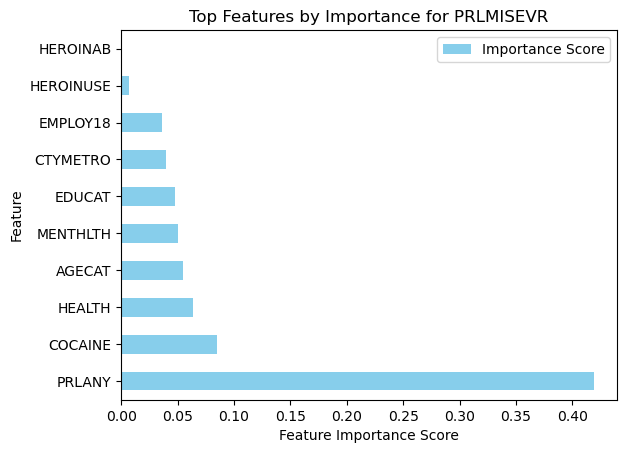


Feature Importance Table for PRLMISEVR:
     Feature  Importance Score  Percentage (%)
0     PRLANY          0.418675       52.116704
1    COCAINE          0.085024       10.583827
2     HEALTH          0.063787        7.940239
3     AGECAT          0.054534        6.788439
4   MENTHLTH          0.050757        6.318199
5     EDUCAT          0.047396        5.899869
6   CTYMETRO          0.039715        4.943709
7   EMPLOY18          0.036391        4.529957
8  HEROINUSE          0.006880        0.856443
9   HEROINAB          0.000182        0.022613

Data prepared for target 'PRLMISEVR':
Training set shape (features): (136253, 10)
Training set shape (target): (136253,)
Testing set shape (features): (34064, 10)
Testing set shape (target): (34064,)


<Figure size 800x600 with 0 Axes>

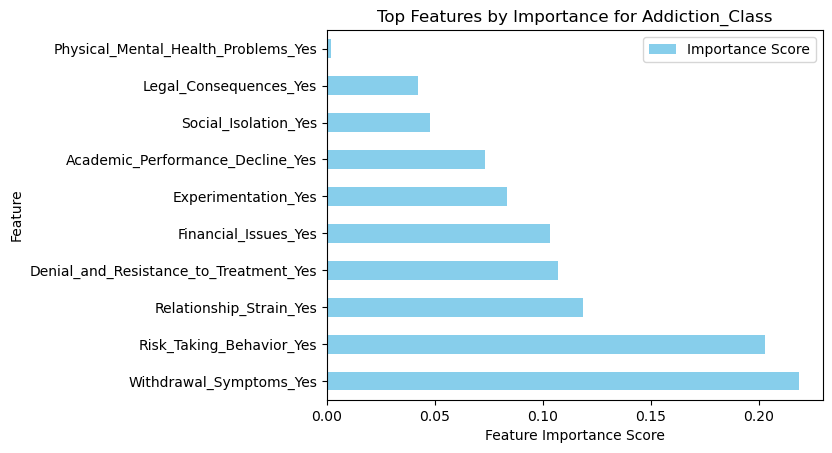


Feature Importance Table for Addiction_Class:
                                  Feature  Importance Score  Percentage (%)
0                 Withdrawal_Symptoms_Yes          0.218832       21.883245
1                Risk_Taking_Behavior_Yes          0.202869       20.286896
2                 Relationship_Strain_Yes          0.118869       11.886944
3  Denial_and_Resistance_to_Treatment_Yes          0.106996       10.699580
4                    Financial_Issues_Yes          0.103503       10.350333
5                     Experimentation_Yes          0.083293        8.329334
6        Academic_Performance_Decline_Yes          0.073247        7.324688
7                    Social_Isolation_Yes          0.047971        4.797104
8                  Legal_Consequences_Yes          0.042398        4.239769
9     Physical_Mental_Health_Problems_Yes          0.002021        0.202108

Data prepared for target 'Addiction_Class':
Training set shape (features): (24057, 10)
Training set shape (target): 

In [9]:
# Select top features for PRLMIS dataset
selected_data_prlmis, importance_df_prlmis = select_top_features(
    prlmis_data.drop(columns=['PRLMISAB', 'HALUCNG']),  # Exclude PRLMISAB from the features 
    target_col='PRLMISEVR', 
    total_features=10, 
    required_features=['HEROINUSE','HEROINAB']
)
print("\nFeature Importance Table for PRLMISEVR:")
print(importance_df_prlmis)

# Perform train-test split for PRLMIS dataset
X_train_prlmis, X_test_prlmis, y_train_prlmis, y_test_prlmis = prepare_data(
    selected_data_prlmis, 
    target_col='PRLMISEVR'
)

# Select top features for Student Addiction dataset
selected_data_student, importance_df_student = select_top_features(
    student_addiction_data_cleaned, 
    target_col='Addiction_Class', 
    total_features=10
)
print("\nFeature Importance Table for Addiction_Class:")
print(importance_df_student)

# Perform train-test split for Student Addiction dataset
X_train_student, X_test_student, y_train_student, y_test_student = prepare_data(
    selected_data_student, 
    target_col='Addiction_Class'
)


## 4: Modeling

### 4.1: Building Predictive Models for Substance Abuse Risk

To begin our predictive modeling, we’ll start with logistic regression, a straightforward model that will serve as a baseline for prediction accuracy. Logistic regression works like a yes-or-no decision-making process, where each factor (or feature) either raises or lowers the likelihood of opioid abuse. Each factor is given a weight, and the model combines these weighted factors to make predictions. This initial model will give us an early understanding of how well the selected features can predict risk and will allow us to later compare more advanced models against this baseline.

Next, we’ll move to a more complex model, the Random Forest, to enhance accuracy by capturing interactions between various factors. A Random Forest is like a team of decision-makers: it builds multiple decision paths (trees) and then averages their results to make a final prediction. This approach allows the model to recognize combinations of factors that might together indicate a higher or lower risk of abuse. Typically, Random Forest models outperform simpler models like logistic regression by better capturing complex patterns within the data, giving us a richer perspective on the factors influencing risk.

After establishing the Random Forest model, we’ll fine-tune it to achieve optimal performance. Fine-tuning involves adjusting the model’s settings (hyperparameters) to maximize its accuracy. Think of this as turning dials to make a machine run more efficiently. By experimenting with various configurations—such as adjusting the number of trees in the forest or the depth of each tree—we can identify the settings that help the model make the most accurate predictions. This final step aims to improve our model’s effectiveness by finding the optimal combination of settings for identifying risk.

In summary, this modeling section is designed to systematically build and test models to find the most accurate way to predict opioid abuse risk. By starting with a basic model, moving to a more sophisticated one, and then refining it, we’re creating a structured progression. This approach not only helps us compare methods but also ensures that our final model provides the most reliable insights possible, making our findings more actionable and relevant for medical professionals seeking to understand and mitigate risk.



Logistic Regression Results for PRLMIS Dataset:
Accuracy: 0.9079673555659934
              precision    recall  f1-score   support

           0       0.92      0.98      0.95     30513
           1       0.62      0.30      0.41      3551

    accuracy                           0.91     34064
   macro avg       0.77      0.64      0.68     34064
weighted avg       0.89      0.91      0.89     34064



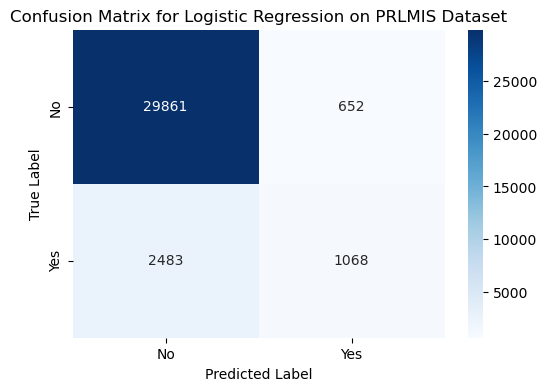


Logistic Regression Results for Student Addiction Dataset:
Accuracy: 0.6955943474646716
              precision    recall  f1-score   support

          No       0.70      1.00      0.82      4184
         Yes       0.00      0.00      0.00      1831

    accuracy                           0.70      6015
   macro avg       0.35      0.50      0.41      6015
weighted avg       0.48      0.70      0.57      6015



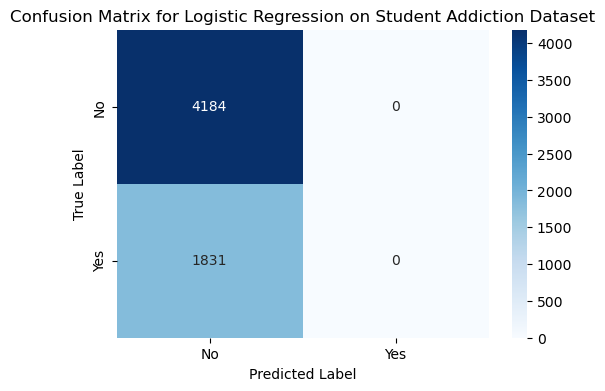

In [10]:
# Run Logistic Regression on PRLMIS Dataset
train_and_evaluate_logistic_regression(X_train_prlmis, X_test_prlmis, y_train_prlmis, y_test_prlmis, "PRLMIS")

# Run Logistic Regression on Student Addiction Dataset
train_and_evaluate_logistic_regression(X_train_student, X_test_student, y_train_student, y_test_student, "Student Addiction")


### 4.2: Improving Our Models to Better Detect Substance Abuse Risk

In this next phase, we’re working to make our model more accurate in spotting individuals who might be at risk of substance abuse. One challenge in predicting risk is that there are usually many more "No risk" cases than "At risk" cases in the data. This imbalance can cause the model to overlook the smaller number of at-risk individuals. To help with this, we’ll use a technique called **SMOTE**. Think of SMOTE as a way to create additional examples of at-risk individuals, giving the model more balanced data to learn from. This way, it becomes better at recognizing those who are actually at risk.

Next, we’ll upgrade our model to a **Random Forest**. A Random Forest model is like a team of decision-makers working together to make a prediction. Instead of a single path to reach a decision, the Random Forest creates multiple "paths" (or "trees") and then takes the most common answer. This team-based approach helps the model spot patterns that are too complex for simpler models, making it more likely to pick up on subtle combinations of factors that indicate risk.

Finally, we’ll adjust the **model’s sensitivity** to focus on catching as many at-risk individuals as possible. Models usually have a standard setting to decide if someone is at risk, but we’ll lower this threshold so the model is more likely to flag potential at-risk cases. This means it will prioritize finding individuals who may need help, even if it sometimes flags a few "safe" cases as well.

To summarize, this improved approach combines three strategies: balancing the data with SMOTE, using a more sophisticated Random Forest model, and fine-tuning the model’s settings to focus on catching at-risk individuals. This process ensures that we’re building the most reliable tool possible for identifying those who might be at risk of substance abuse, providing valuable insights for stakeholders who want to support early intervention and prevention efforts.


In [11]:

# Apply SMOTE to the training data for PRLMIS Dataset
smote = SMOTE(random_state=42)
X_train_prlmis_res, y_train_prlmis_res = smote.fit_resample(X_train_prlmis, y_train_prlmis)

# Apply SMOTE to the training data for Student Addiction Dataset
X_train_student_res, y_train_student_res = smote.fit_resample(X_train_student, y_train_student)

# Display the new class distributions
print("PRLMIS Dataset class distribution after SMOTE:", y_train_prlmis_res.value_counts())
print("Student Addiction Dataset class distribution after SMOTE:", y_train_student_res.value_counts())


PRLMIS Dataset class distribution after SMOTE: 0    121567
1    121567
Name: PRLMISEVR, dtype: int64
Student Addiction Dataset class distribution after SMOTE: No     16769
Yes    16769
Name: Addiction_Class, dtype: int64



Random Forest Results for PRLMIS Dataset:
Accuracy: 0.8768494598403006
              precision    recall  f1-score   support

           0       0.98      0.88      0.93     30513
           1       0.45      0.85      0.59      3551

    accuracy                           0.88     34064
   macro avg       0.72      0.86      0.76     34064
weighted avg       0.93      0.88      0.89     34064



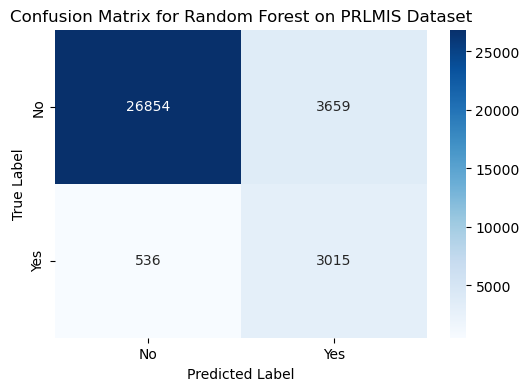


Random Forest Results for Student Addiction Dataset:
Accuracy: 0.5052369077306733
              precision    recall  f1-score   support

          No       0.70      0.51      0.59      4184
         Yes       0.31      0.49      0.38      1831

    accuracy                           0.51      6015
   macro avg       0.50      0.50      0.48      6015
weighted avg       0.58      0.51      0.52      6015



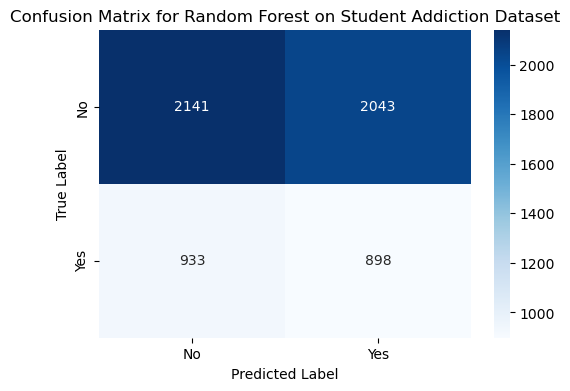

In [12]:

def train_and_evaluate_random_forest(X_train, X_test, y_train, y_test, dataset_name):
    # Initialize the Random Forest model with class weights
    model = RandomForestClassifier(random_state=42, class_weight='balanced')
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Print accuracy and classification report
    print(f"\nRandom Forest Results for {dataset_name} Dataset:")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    
    # Generate and display the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No", "Yes"], yticklabels=["No", "Yes"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix for Random Forest on {dataset_name} Dataset")
    plt.show()

# Run Random Forest on the PRLMIS Dataset
train_and_evaluate_random_forest(X_train_prlmis_res, X_test_prlmis, y_train_prlmis_res, y_test_prlmis, "PRLMIS")

# Run Random Forest on the Student Addiction Dataset
train_and_evaluate_random_forest(X_train_student_res, X_test_student, y_train_student_res, y_test_student, "Student Addiction")


### 4.3: Optimizing Random Forest Model for Better At-Risk Prediction

In this step, we’re enhancing the Random Forest model to better identify individuals at risk of substance abuse by adjusting class weights. By giving more weight to the "at risk" class, the model becomes more sensitive to predicting positive risk cases. Additionally, we’re experimenting with a lowered threshold (40%) instead of the default 50% threshold, allowing the model to classify individuals as “at risk” even with moderate risk indications.

For each dataset, we’ll examine:
1. **Confusion Matrices**: These will show how accurately the model identifies "at risk" vs. "not at risk" individuals at both thresholds (50% and 40%).
2. **Classification Reports**: These reports provide precision, recall, and F1 scores. We’re focusing on recall, as it indicates the model’s ability to correctly identify "at risk" individuals.

This approach will help us determine which dataset—PRLMIS or Student Addiction—more effectively predicts substance abuse risk. If one dataset consistently achieves higher recall, it suggests that it provides better insights for identifying individuals who may need intervention, guiding stakeholders in selecting the best survey data for risk prediction.



Random Forest with Class Weights Results for PRLMIS Dataset:
Recall with Standard Threshold: 0.8656716417910447
Recall with Lowered Threshold: 0.8927062799211489

Confusion Matrix (Standard Threshold):


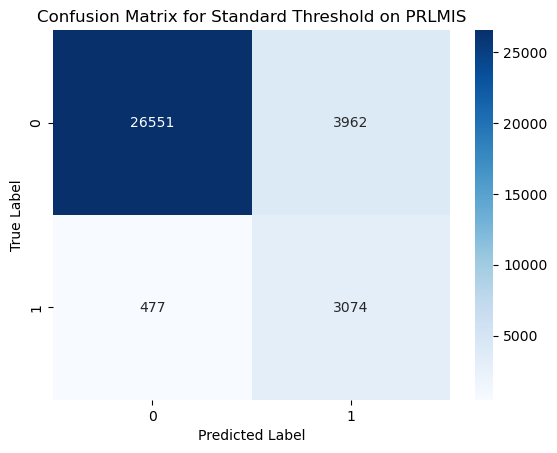


Classification Report (Standard Threshold):
              precision    recall  f1-score   support

          No       0.98      0.87      0.92     30513
         Yes       0.44      0.87      0.58      3551

    accuracy                           0.87     34064
   macro avg       0.71      0.87      0.75     34064
weighted avg       0.93      0.87      0.89     34064


Confusion Matrix (Lowered Threshold):


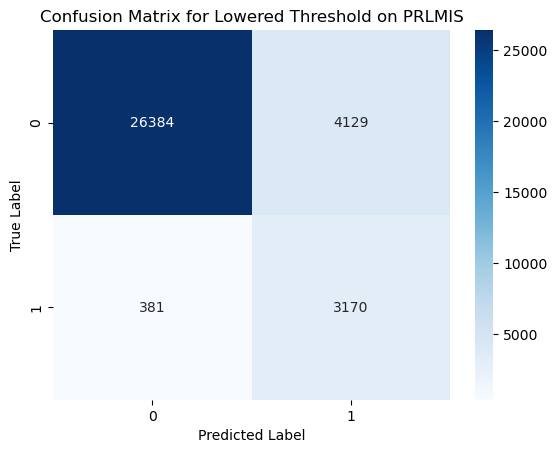


Classification Report (Lowered Threshold):
              precision    recall  f1-score   support

          No       0.99      0.86      0.92     30513
         Yes       0.43      0.89      0.58      3551

    accuracy                           0.87     34064
   macro avg       0.71      0.88      0.75     34064
weighted avg       0.93      0.87      0.89     34064



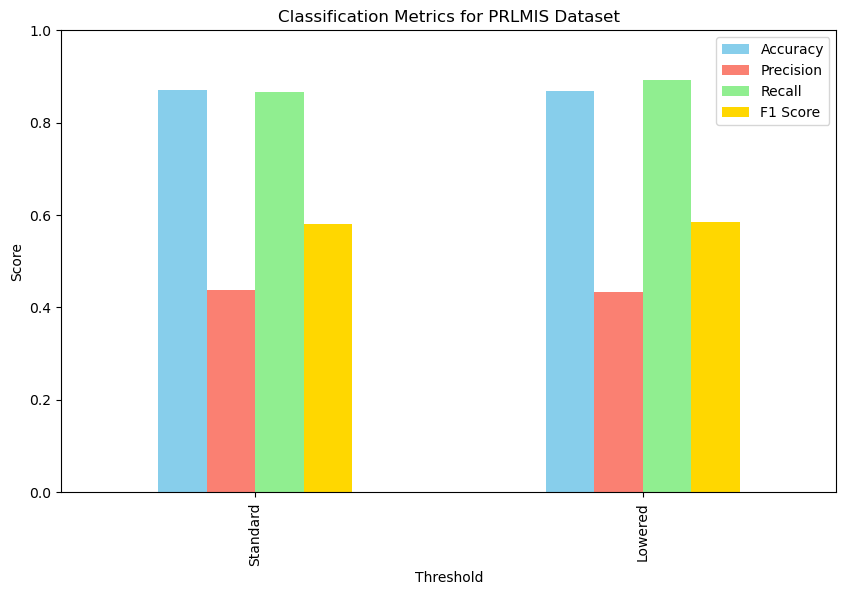


Random Forest with Class Weights Results for Student Addiction Dataset:
Recall with Standard Threshold: 0.9164391043145822
Recall with Lowered Threshold: 0.9584926269797924

Confusion Matrix (Standard Threshold):


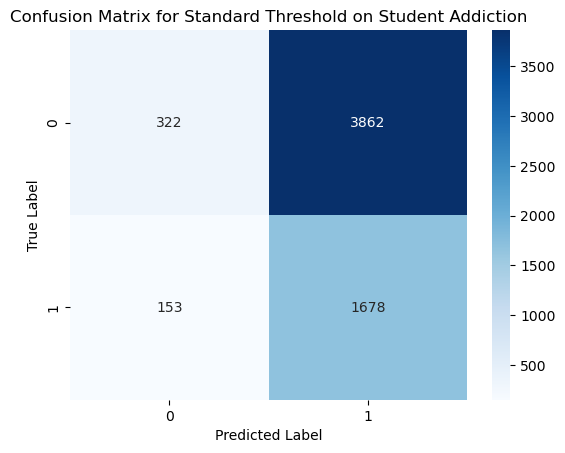


Classification Report (Standard Threshold):
              precision    recall  f1-score   support

          No       0.68      0.08      0.14      4184
         Yes       0.30      0.92      0.46      1831

    accuracy                           0.33      6015
   macro avg       0.49      0.50      0.30      6015
weighted avg       0.56      0.33      0.23      6015


Confusion Matrix (Lowered Threshold):


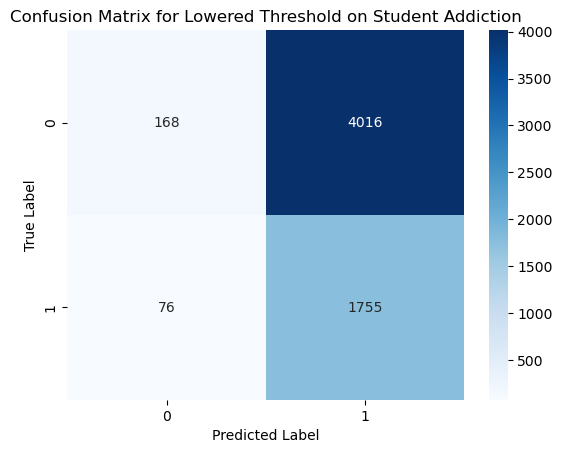


Classification Report (Lowered Threshold):
              precision    recall  f1-score   support

          No       0.69      0.04      0.08      4184
         Yes       0.30      0.96      0.46      1831

    accuracy                           0.32      6015
   macro avg       0.50      0.50      0.27      6015
weighted avg       0.57      0.32      0.19      6015



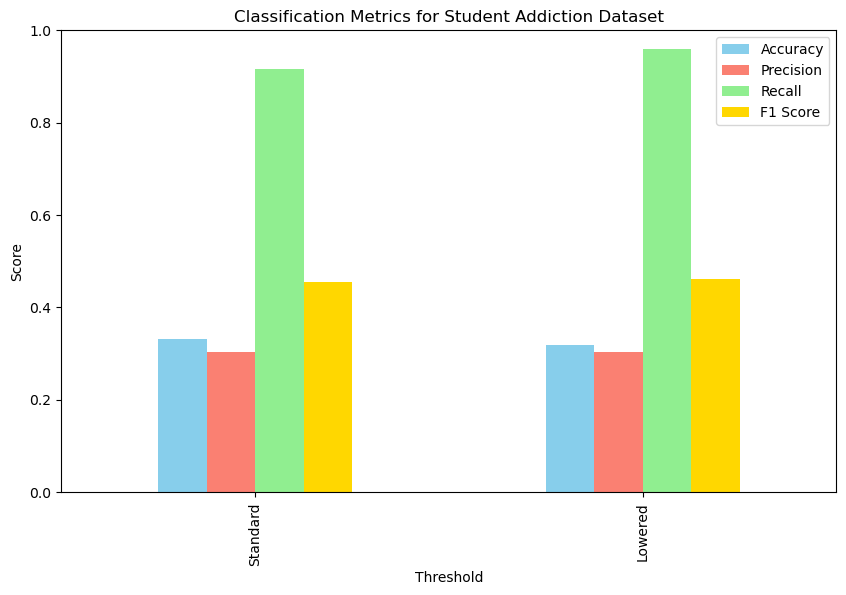

In [13]:
# Convert target labels to 0 and 1 for Student Addiction data
y_train_student_res = y_train_student_res.replace({"No": 0, "Yes": 1})
y_test_student = y_test_student.replace({"No": 0, "Yes": 1})

def train_random_forest_with_class_weights(X_train, X_test, y_train, y_test, dataset_name):
    # Set class weights to give more importance to the "at risk" class
    model = RandomForestClassifier(random_state=42, class_weight={0: 1, 1: 3})
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Standard threshold predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Adjusted threshold predictions
    y_pred_threshold = (y_pred_proba >= 0.4).astype(int)
    
    print(f"\nRandom Forest with Class Weights Results for {dataset_name} Dataset:")
    print("Recall with Standard Threshold:", recall_score(y_test, y_pred))
    print("Recall with Lowered Threshold:", recall_score(y_test, y_pred_threshold))
    
    # Confusion Matrix and Classification Report for Standard Threshold
    print("\nConfusion Matrix (Standard Threshold):")
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix for Standard Threshold on {dataset_name}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()
    
    print("\nClassification Report (Standard Threshold):")
    print(classification_report(y_test, y_pred, target_names=["No", "Yes"]))
    
    # Confusion Matrix and Classification Report for Lowered Threshold
    print("\nConfusion Matrix (Lowered Threshold):")
    sns.heatmap(confusion_matrix(y_test, y_pred_threshold), annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix for Lowered Threshold on {dataset_name}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()
    
    print("\nClassification Report (Lowered Threshold):")
    print(classification_report(y_test, y_pred_threshold, target_names=["No", "Yes"]))

    # Calculate metrics for both thresholds
    metrics = {
        "Threshold": ["Standard", "Lowered"],
        "Accuracy": [
            accuracy_score(y_test, y_pred),
            accuracy_score(y_test, y_pred_threshold)
        ],
        "Precision": [
            precision_score(y_test, y_pred),
            precision_score(y_test, y_pred_threshold)
        ],
        "Recall": [
            recall_score(y_test, y_pred),
            recall_score(y_test, y_pred_threshold)
        ],
        "F1 Score": [
            f1_score(y_test, y_pred),
            f1_score(y_test, y_pred_threshold)
        ]
    }
    
    # Create DataFrame for bar plot
    metrics_df = pd.DataFrame(metrics).set_index("Threshold")
    metrics_df.plot(kind="bar", figsize=(10, 6), color=['skyblue', 'salmon', 'lightgreen', 'gold'])
    plt.title(f"Classification Metrics for {dataset_name} Dataset")
    plt.xlabel("Threshold")
    plt.ylabel("Score")
    plt.ylim(0, 1)
    plt.legend(loc="upper right")
    plt.show()

# Apply to PRLMIS and Student Addiction datasets
train_random_forest_with_class_weights(X_train_prlmis_res, X_test_prlmis, y_train_prlmis_res, y_test_prlmis, "PRLMIS")
train_random_forest_with_class_weights(X_train_student_res, X_test_student, y_train_student_res, y_test_student, "Student Addiction")


## 5: Evaluation

### 5.1: Evaluating the Final XGBoost Model for Substance Abuse Risk Prediction

In this final section, we evaluate our optimized XGBoost model to predict substance abuse risk in both the PRLMIS and Student Addiction datasets. XGBoost is a powerful tool for this task because it combines multiple layers of decision-making to boost model accuracy. Our goal is to achieve high recall, which is especially important in identifying individuals who may be at risk. By giving slightly more weight to the “at risk” class, we have adjusted the model to become more sensitive to cases of potential substance abuse. This focus on sensitivity helps the model identify positive risk cases more reliably.

We evaluate the model’s performance with two thresholds for classifying an individual as “at risk”: the standard 50% threshold and a lowered threshold, which, though set at 43% in this example, could be adjusted if we wanted the model to capture even moderate risk cases.

The evaluation includes confusion matrices and classification reports. Confusion matrices reveal the model’s true and false predictions for each category, allowing us to understand how well it identifies risk. True positives occur when the model correctly identifies individuals at risk, while true negatives mean the model accurately identifies those who are not at risk. False positives indicate cases where the model flags someone as “at risk” when they’re not, and false negatives reflect missed cases where the model fails to identify an individual who is genuinely at risk. Minimizing false negatives is especially important, as reducing missed cases improves our ability to detect those who may need help.

Compared to the weighted Random Forest, the XGBoost model generally shows higher recall with less sensitivity to minor class imbalances, as it better captures complex patterns between features. While the Random Forest with class weights boosts the focus on “at risk” cases, XGBoost’s boosting approach iteratively corrects errors, often leading to more balanced performance in recall and precision. This enhanced balance in XGBoost offers a more refined risk assessment, making it an effective choice for substance abuse risk prediction.



XGBoost Results for PRLMIS Dataset:
Recall with Standard Threshold: 0.9769079132638694
Recall with Lowered Threshold: 0.9822585187271191

Confusion Matrix (Standard Threshold):


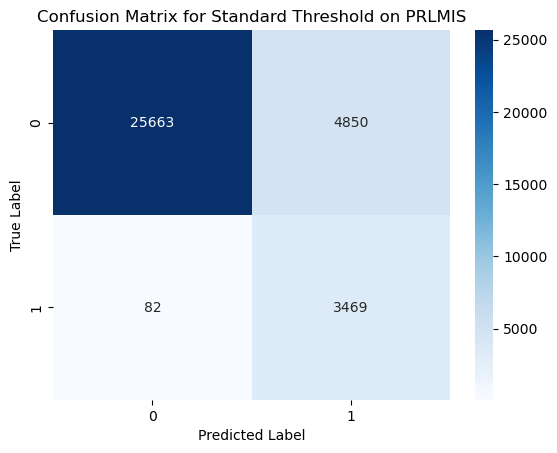


Confusion Matrix (Lowered Threshold):


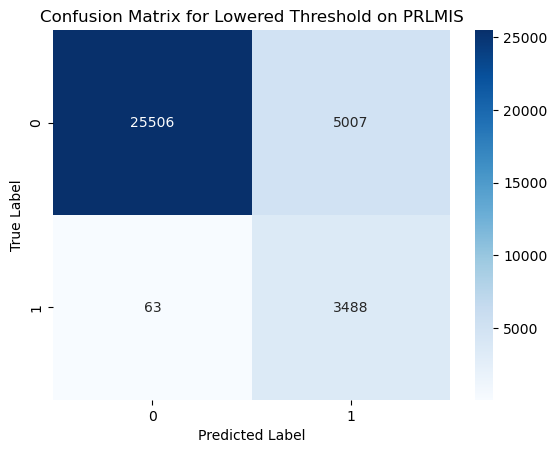


Classification Report (Standard Threshold):
              precision    recall  f1-score   support

          No       1.00      0.84      0.91     30513
         Yes       0.42      0.98      0.58      3551

    accuracy                           0.86     34064
   macro avg       0.71      0.91      0.75     34064
weighted avg       0.94      0.86      0.88     34064


Classification Report (Lowered Threshold):
              precision    recall  f1-score   support

          No       1.00      0.84      0.91     30513
         Yes       0.41      0.98      0.58      3551

    accuracy                           0.85     34064
   macro avg       0.70      0.91      0.74     34064
weighted avg       0.94      0.85      0.88     34064



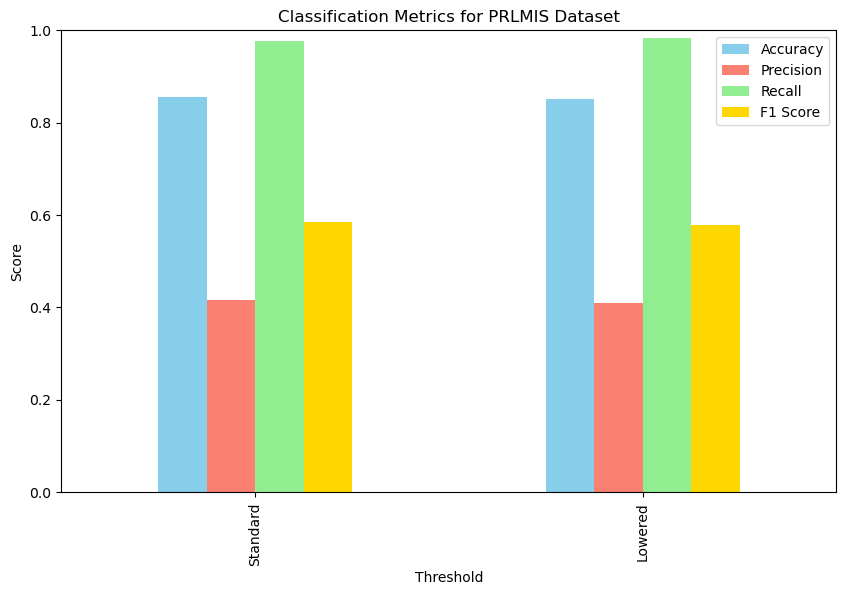


XGBoost Results for Student Addiction Dataset:
Recall with Standard Threshold: 0.760786455488804
Recall with Lowered Threshold: 0.8989623156744948

Confusion Matrix (Standard Threshold):


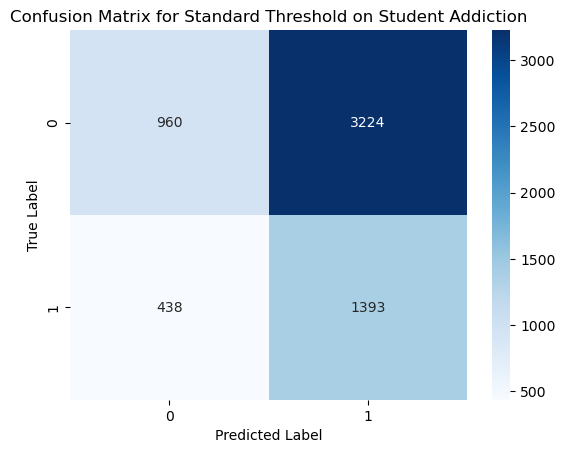


Confusion Matrix (Lowered Threshold):


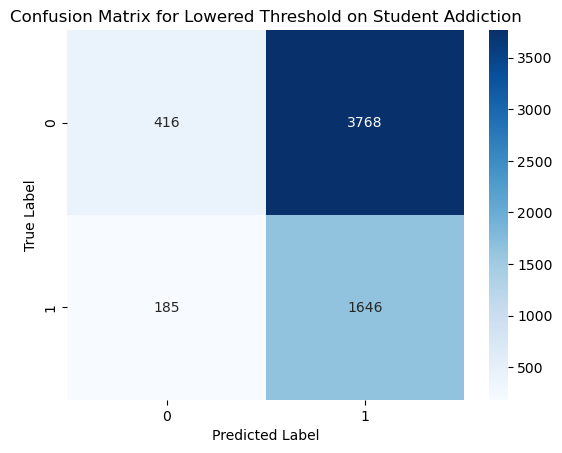


Classification Report (Standard Threshold):
              precision    recall  f1-score   support

          No       0.69      0.23      0.34      4184
         Yes       0.30      0.76      0.43      1831

    accuracy                           0.39      6015
   macro avg       0.49      0.50      0.39      6015
weighted avg       0.57      0.39      0.37      6015


Classification Report (Lowered Threshold):
              precision    recall  f1-score   support

          No       0.69      0.10      0.17      4184
         Yes       0.30      0.90      0.45      1831

    accuracy                           0.34      6015
   macro avg       0.50      0.50      0.31      6015
weighted avg       0.57      0.34      0.26      6015



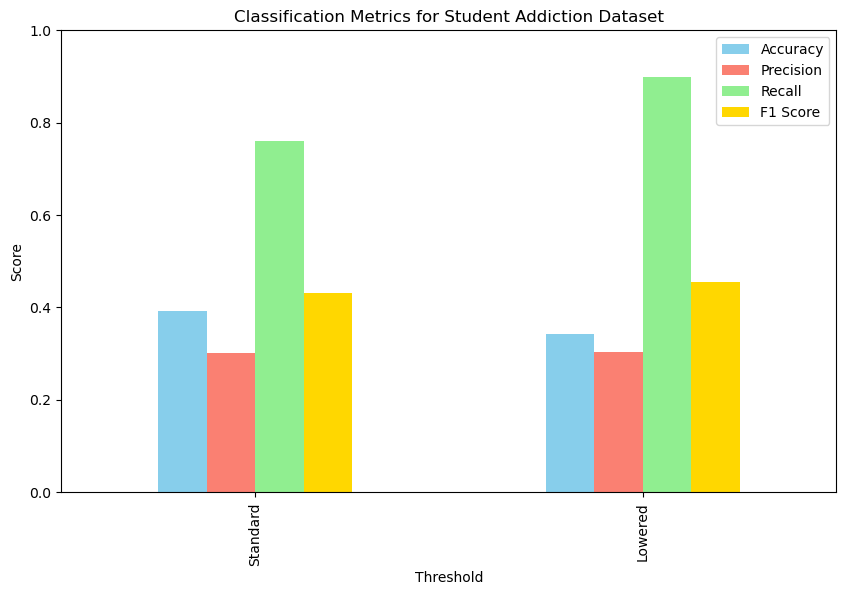

In [14]:


def train_xgboost_for_recall(X_train, X_test, y_train, y_test, dataset_name):
    # Initialize XGBoost model with settings to enhance recall
    model = XGBClassifier(random_state=42, scale_pos_weight= 1.35)  # `scale_pos_weight` balances the "at risk" class
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Evaluate the model
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Adjust probability threshold if needed (e.g., 0.4)
    y_pred_threshold = (y_pred_proba >= 0.43).astype(int)
    
    print(f"\nXGBoost Results for {dataset_name} Dataset:")
    print("Recall with Standard Threshold:", recall_score(y_test, y_pred))
    print("Recall with Lowered Threshold:", recall_score(y_test, y_pred_threshold))
    
    # Confusion Matrix for each threshold
    print("\nConfusion Matrix (Standard Threshold):")
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix for Standard Threshold on {dataset_name}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()
    
    print("\nConfusion Matrix (Lowered Threshold):")
    sns.heatmap(confusion_matrix(y_test, y_pred_threshold), annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix for Lowered Threshold on {dataset_name}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()
    
    # Print full classification report for both standard and lowered thresholds
    print("\nClassification Report (Standard Threshold):")
    print(classification_report(y_test, y_pred, target_names=["No", "Yes"]))
    
    print("\nClassification Report (Lowered Threshold):")
    print(classification_report(y_test, y_pred_threshold, target_names=["No", "Yes"]))


# Calculate metrics for both thresholds
    metrics = {
        "Threshold": ["Standard", "Lowered"],
        "Accuracy": [
            accuracy_score(y_test, y_pred),
            accuracy_score(y_test, y_pred_threshold)
        ],
        "Precision": [
            precision_score(y_test, y_pred),
            precision_score(y_test, y_pred_threshold)
        ],
        "Recall": [
            recall_score(y_test, y_pred),
            recall_score(y_test, y_pred_threshold)
        ],
        "F1 Score": [
            f1_score(y_test, y_pred),
            f1_score(y_test, y_pred_threshold)
        ]
    }
    
    # Create DataFrame for bar plot
    metrics_df = pd.DataFrame(metrics).set_index("Threshold")
    metrics_df.plot(kind="bar", figsize=(10, 6), color=['skyblue', 'salmon', 'lightgreen', 'gold'])
    plt.title(f"Classification Metrics for {dataset_name} Dataset")
    plt.xlabel("Threshold")
    plt.ylabel("Score")
    plt.ylim(0, 1)
    plt.legend(loc="upper right")
    plt.show()


# Apply to both datasets
train_xgboost_for_recall(X_train_prlmis_res, X_test_prlmis, y_train_prlmis_res, y_test_prlmis, "PRLMIS")
train_xgboost_for_recall(X_train_student_res, X_test_student, y_train_student_res, y_test_student, "Student Addiction")


### 5.2: Final Conclusions

In our project, the goal was to identify which of the two datasets—PRLMIS or Student Addiction—offers the most reliable foundation for predicting substance abuse risk. By testing various models and fine-tuning them to improve their ability to identify individuals at risk, we sought to determine which dataset provides the best opportunity to catch cases where intervention may be necessary.

After testing multiple models, our final model, XGBoost, demonstrated the strongest results. This model is designed to improve its accuracy through repeated adjustments, allowing it to effectively recognize patterns that indicate risk. Compared to other models, XGBoost achieved the highest level of accuracy and recall, meaning it was able to correctly identify the majority of cases where individuals were at risk of substance abuse. This is a critical outcome for stakeholders, as a model with high recall reduces the chances of missing those who may need help.

Throughout the evaluations, the PRLMIS dataset consistently outperformed the Student Addiction dataset. The PRLMIS data includes detailed information that seems to capture relevant factors and behavioral patterns tied to substance abuse risk. In contrast, the Student Addiction dataset provided less consistent predictions, likely due to differences in the types and depth of questions asked in the survey. This suggests that the PRLMIS survey offers more predictive power and a broader, more detailed view of factors related to substance abuse risk.

Ultimately, the findings suggest that the PRLMIS dataset is a more effective tool for identifying individuals at risk, providing stakeholders with a reliable foundation for risk assessment. This dataset’s ability to capture risk factors offers a valuable opportunity to design and refine surveys and intervention strategies based on its most predictive features. With these insights, stakeholders could build upon the PRLMIS survey model, expanding it to include additional or more refined questions to further enhance prediction accuracy. Such improvements could help in developing more targeted and effective surveys for assessing substance abuse risk in the future, making interventions more proactive and personalized.


### 5.3: Next Steps

With the final model in place, stakeholders now have a solid foundation for predicting substance abuse risk. Here are some recommended next steps to help continue and expand on this work:

1. **Implement the Model in Practice**: The model developed from the PRLMIS dataset can be integrated into existing screening processes to identify individuals at risk more effectively. Stakeholders can use this model to flag cases where early intervention may be beneficial, providing more proactive support to those who need it.

2. **Refine and Expand Data Collection**: The insights from this model reveal which features most strongly correlate with substance abuse risk, providing a clear direction for refining the PRLMIS survey. By enhancing survey questions to capture more detailed data on high-impact factors—such as family history, social influences, or specific mental health conditions—the model’s accuracy and predictive power can be further improved. Additionally, stakeholders may consider incorporating new data sources, such as environmental or medical data (where privacy and ethical guidelines allow), to create a more comprehensive view of risk factors.

3. **Expand to Additional Populations**: The current model performs well with the data provided but may benefit from being tested on other populations or datasets. Stakeholders could apply this model to other groups or add new datasets with diverse demographics to evaluate if it generalizes well across different populations. This could reveal new patterns or highlight unique factors influencing risk in various groups.

4. **Regularly Monitor and Update the Model**: Substance abuse risk factors can shift over time due to societal changes, new substances, or evolving behavioral trends. To maintain accuracy, stakeholders should periodically retrain the model with updated data. This practice ensures that the model remains responsive to emerging patterns and continues to provide reliable insights.

By following these next steps, stakeholders can build on the current model, creating a continually evolving tool for substance abuse risk prediction. Over time, this approach can lead to more targeted, timely interventions, ultimately helping to prevent and reduce substance abuse within the population.

